# Import Necessary Libraries 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import copy
import tensorflow as tf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

# Data Preprocessing 

In [11]:
#Connects to directory where cvs spreadsheets are sotred
os.chdir("c:/Users/Tani/Documents/CompSciProject/")
path = "c:/Users/Tani/Documents/CompSciProject/"
csv_files = glob.glob(path + "/*.csv")

In [12]:
#Reads in the spred sheets
df_list = (pd.read_csv(file) for file in csv_files)
matches1 =pd.read_csv('2020-2021.csv')
matches2 = pd.read_csv('2021-2022.csv')



In [13]:
#Gets a list of all the home teams
teams1 = matches1['HomeTeam'].tolist()
teams2 = matches2['HomeTeam'].tolist()

#ensures that there are no duplicates 
list_teams1 = list(set(teams1))
list_teams2 = list(set(teams2))


In [14]:
print(list_teams1)
print(list_teams2)

['Leicester', 'Arsenal', 'Tottenham', 'Burnley', 'Fulham', 'Everton', 'Sheffield United', 'Liverpool', 'Wolves', 'Aston Villa', 'Brighton', 'Leeds', 'Man City', 'West Brom', 'Southampton', 'West Ham', 'Chelsea', 'Crystal Palace', 'Man United', 'Newcastle']
['Leicester', 'Arsenal', 'Burnley', 'Tottenham', 'Norwich', 'Everton', 'Liverpool', 'Wolves', 'Aston Villa', 'Brighton', 'Leeds', 'Man City', 'Watford', 'Southampton', 'Brentford', 'West Ham', 'Chelsea', 'Crystal Palace', 'Man United', 'Newcastle']


In [15]:
#Drops uneccessary colummns from the dataframe 

colsToKeep = list(["Div","Date","HomeTeam","AwayTeam","FTHG","FTAG","FTR","Coded FTR","HTHG","HTAG","HTR","HS","AS","HST","AST","HC","AC","HF","AF","HY","AY","HR","AR"])
allcols = matches1.columns
colsToDrop = set(allcols) - set(colsToKeep)
matches1 = pd.DataFrame(matches1.drop(labels=colsToDrop,axis=1))
matches2 = pd.DataFrame(matches2.drop(labels=colsToDrop,axis=1))

In [16]:
# Define a custom function to calculate the goals conceded by the home team
def home_goals_conceded(row):
    return row['FTAG']

# Define a custom function to calculate the goals conceded by the away team
def away_goals_conceded(row):
    return row['FTHG']


# Apply the custom functions to each row of the DataFrame
matches1['HGC'] = matches1.apply(home_goals_conceded, axis=1)
matches1['AGC'] = matches1.apply(away_goals_conceded, axis=1)

matches2['HGC'] = matches2.apply(home_goals_conceded, axis=1)
matches2['AGC'] = matches2.apply(away_goals_conceded, axis=1)

In [17]:
def goal_difference(row):
    return (row['FTHG'] - row['FTAG'])


matches1['Goal Difference'] = matches1.apply(goal_difference, axis=1)
matches2['Goal Difference'] = matches2.apply(goal_difference, axis=1)

In [18]:
# Sort the list of teams alphabetically
sorted_teams1 = sorted(list_teams1)
sorted_teams2 = sorted(list_teams2)

# Create a new DataFrame with the sorted teams as the index
league_table1 = pd.DataFrame(index=sorted_teams1)
league_table2 = pd.DataFrame(index=sorted_teams2)


# Add columns for the points, wins, draws, losses, goals for, goals against, and goal difference
league_table1['Points'] = 0
league_table1['Wins'] = 0
league_table1['Draws'] = 0
league_table1['Losses'] = 0
league_table1['Goals For'] = 0
league_table1['Goals Against'] = 0

league_table2['Points'] = 0
league_table2['Wins'] = 0
league_table2['Draws'] = 0
league_table2['Losses'] = 0
league_table2['Goals For'] = 0
league_table2['Goals Against'] = 0


# Define a function to calculate the current position of each team in the league table
def calculate_position(row,league_table):
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    home_goals = row['FTHG']
    away_goals = row['FTAG']

    # Update the league table based on the result of the match
    if home_goals > away_goals:
        league_table.loc[home_team, 'Points'] += 3
        league_table.loc[home_team, 'Wins'] += 1
        league_table.loc[home_team, 'Goals For'] += home_goals
        league_table.loc[home_team, 'Goals Against'] += away_goals
        league_table.loc[away_team, 'Losses'] += 1
        league_table.loc[away_team, 'Goals For'] += away_goals
        league_table.loc[away_team, 'Goals Against'] += home_goals
    elif home_goals < away_goals:
        league_table.loc[away_team, 'Points'] += 3
        league_table.loc[away_team, 'Wins'] += 1
        league_table.loc[away_team, 'Goals For'] += away_goals
        league_table.loc[away_team, 'Goals Against'] += home_goals
        league_table.loc[home_team, 'Goals For'] += home_goals
        league_table.loc[home_team, 'Losses'] += 1
        league_table.loc[home_team, 'Goals Against'] += away_goals
    else:
        league_table.loc[home_team, 'Points'] += 1
        league_table.loc[home_team, 'Draws'] += 1
        league_table.loc[home_team, 'Goals For'] += home_goals
        league_table.loc[home_team, 'Goals Against'] += away_goals
        league_table.loc[away_team, 'Points'] += 1
        league_table.loc[away_team, 'Draws'] += 1
        league_table.loc[away_team, 'Goals For'] += away_goals
        league_table.loc[away_team, 'Goals Against'] += home_goals
    
    league_table['Goal Difference'] = league_table['Goals For'] - league_table['Goals Against']
    league_table = league_table.sort_values(['Points'] ,ascending=[False])
    league_table['Position'] = range(1, len(league_table) + 1)

    home_pos = league_table.loc[home_team, 'Position']
    away_pos = league_table.loc[away_team, 'Position']
    
    return home_pos - away_pos

    # Return the position of each team in the league table
    #return ((league_table.loc[home_team,'Position'] - league_table.loc[away_team,'Position']))
    


# Apply the function to each row of the matches data frame and create two new columns with the results
matches1['League Table Difference'] = matches1.apply(lambda row: calculate_position(row, league_table1), axis=1)
matches2['League Table Difference'] = matches2.apply(lambda row: calculate_position(row, league_table2), axis=1)

In [19]:
#Function to group the  matches into rolling averages
def rolling_averages(group,cols,new_cols):
    group = group.sort_values("Date")
    rolling_stats = group[cols].rolling(5,closed = 'left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    
    return group

In [20]:
#Create the rolling features columns 
cols = ["FTHG","FTAG","HTHG","HTAG","Coded FTR","HS","AS","HST","AST","HC","AC","HF","AF","HY","AY","HR","AR","HGC","AGC"]
new_cols = [f"{c}_rolling" for c in cols]
print(new_cols)

['FTHG_rolling', 'FTAG_rolling', 'HTHG_rolling', 'HTAG_rolling', 'Coded FTR_rolling', 'HS_rolling', 'AS_rolling', 'HST_rolling', 'AST_rolling', 'HC_rolling', 'AC_rolling', 'HF_rolling', 'AF_rolling', 'HY_rolling', 'AY_rolling', 'HR_rolling', 'AR_rolling', 'HGC_rolling', 'AGC_rolling']


In [21]:
#Applying the rolling averaes function to each of the dataframes 
matches1_rolling = matches1.groupby("HomeTeam").apply(lambda x: rolling_averages(x,cols,new_cols))
matches2_rolling = matches2.groupby("HomeTeam").apply(lambda x: rolling_averages(x,cols,new_cols))

print(matches1_rolling)


             Div        Date HomeTeam        AwayTeam  FTHG  FTAG FTR  HTHG  \
HomeTeam                                                                      
Arsenal  178  E0  18/01/2021  Arsenal       Newcastle     3     0   H     0   
         313  E0  18/04/2021  Arsenal          Fulham     1     1   D     0   
         11   E0  19/09/2020  Arsenal        West Ham     2     1   H     1   
         244  E0  21/02/2021  Arsenal        Man City     0     1   A     0   
         320  E0  23/04/2021  Arsenal         Everton     0     1   A     0   
...           ..         ...      ...             ...   ...   ...  ..   ...   
Wolves   58   E0  30/10/2020   Wolves  Crystal Palace     2     0   H     2   
         35   E0   4/10/2020   Wolves          Fulham     1     0   H     0   
         299  E0    5/4/2021   Wolves        West Ham     2     3   A     1   
         221  E0    7/2/2021   Wolves       Leicester     0     0   D     0   
         342  E0    9/5/2021   Wolves        Brighto

In [22]:
#Concatenating both of the dataframes into one single frame 
matches_concat = pd.concat([matches1_rolling,matches2_rolling], ignore_index=True)

In [23]:

# Total number of matches.
n_matches = matches_concat.shape[0]

#Matches won by home team
n_homewins = len(matches_concat[matches_concat.FTR == 'H'])

#percentage of matches won by home team
win_rate = (float(n_homewins) / (n_matches)) * 100

print ("Total number of matches: {}".format(n_matches))
print ("Number of matches won by home team: {}".format(n_homewins))
print ("Win rate of home team: {:.2f}%".format(win_rate))

Total number of matches: 560
Number of matches won by home team: 225
Win rate of home team: 40.18%


In [26]:
home_stats = matches_concat.groupby('HomeTeam')[['FTHG', 'HTHG', 'HS', 'HST', 'HC', 'HF', 'HY', 'HR','HGC']].mean()

# Rename the columns to make them more descriptive
home_stats = home_stats.rename(columns={'FTHG': 'Average Home Goals Scored', 'HTHG': 'Average Home Half-time Goals Scored', 
                                        'HS': 'Average Home Shots', 'HST': 'Average Home Shots on Target', 'HC': 'Average Home Corners', 
                                        'HF': 'Average Home Fouls', 'HY': 'Average Home Yellow Cards', 'HR': 'Average Home Red Cards','HGC':'Average Home goals Conceded'})

# Group the data by away team and calculate the mean of the away statistics columns
away_stats = matches_concat.groupby('AwayTeam')[['FTAG', 'HTAG', 'AS', 'AST', 'AC', 'AF', 'AY', 'AR','AGC']].mean()

# Rename the columns to make them more descriptive
away_stats = away_stats.rename(columns={'FTAG': 'Average Away Goals Scored', 'HTAG': 'Average Away Half-time Goals Scored', 
                                        'AS': 'Average Away Shots', 'AST': 'Average Away Shots on Target', 'AC': 'Average Away Corners', 
                                        'AF': 'Average Away Fouls', 'AY': 'Average Away Yellow Cards', 'AR': 'Average Away Red Cards','AGC':'Average Away goals Conceded'})

In [25]:
selected_columns = ['FTHG_rolling', 'FTAG_rolling', 'HTHG_rolling', 'HTAG_rolling', 'Coded FTR_rolling',
                    'HS_rolling', 'AS_rolling', 'HST_rolling', 'AST_rolling', 'HC_rolling', 'AC_rolling',
                    'HY_rolling', 'AY_rolling', 'AR_rolling', 'HGC_rolling', 'AGC_rolling','League Table Difference']

# Select the features dataframe with the selected columns
features = matches_concat[selected_columns]

# Instantiate the StandardScaler
scaler = MinMaxScaler()

# Scale only the selected columns
features_scaled = scaler.fit_transform(features)

# Merge the scaled features and the home and away team positions into a single dataframe
features_scaled_df = pd.concat([pd.DataFrame(features_scaled, columns=selected_columns), 
                                matches_concat[['Coded FTR','League Table Difference',"Date"]]], axis=1)

features_for_pca = pd.concat([pd.DataFrame(features_scaled, columns=selected_columns)], axis=1)

target = matches_concat[["Coded FTR"]]

In [36]:
from sklearn.decomposition import PCA
x = features_for_pca
pca = PCA(n_components=8)
principalComponents = pca.fit_transform(x)

# Get the loadings (feature contributions) for each principal component
#pca_data = pca.fit_transform(scaled_data)

# Get the principal components (eigenvectors) and sort them
principal_components = pca.components_
feature_names = x.columns
weight = 0
# Display the top features that make up each principal component
for i, component in enumerate(principal_components):
    component_features = list(zip(feature_names, component))
    component_features.sort(key=lambda x: x[1], reverse=True)
    print(f"Principal Component {i+1}:")
    for feature, weight in component_features:
        print(f"{feature}: {weight:.4f}")
    print("\n")
   
    
    


Principal Component 1:
Coded FTR_rolling: 0.3916
HST_rolling: 0.2985
AGC_rolling: 0.2834
FTHG_rolling: 0.2834
HS_rolling: 0.2602
HTHG_rolling: 0.2226
HC_rolling: 0.1835
AR_rolling: 0.0623
AY_rolling: 0.0168
HY_rolling: -0.1156
AC_rolling: -0.1723
League Table Difference: -0.2405
AST_rolling: -0.2464
FTAG_rolling: -0.2545
HGC_rolling: -0.2545
AS_rolling: -0.2624
HTAG_rolling: -0.2861


Principal Component 2:
HTAG_rolling: 0.4921
FTAG_rolling: 0.4002
HGC_rolling: 0.4002
HTHG_rolling: 0.3160
AGC_rolling: 0.2770
FTHG_rolling: 0.2770
HST_rolling: 0.2244
AST_rolling: 0.1948
HS_rolling: 0.1059
AS_rolling: 0.0896
HC_rolling: 0.0861
AR_rolling: 0.0652
AY_rolling: 0.0471
Coded FTR_rolling: -0.0056
HY_rolling: -0.0602
AC_rolling: -0.0762
League Table Difference: -0.2311


Principal Component 3:
HC_rolling: 0.2922
HTAG_rolling: 0.2432
HS_rolling: 0.2171
FTAG_rolling: 0.0799
HGC_rolling: 0.0799
HY_rolling: 0.0782
AR_rolling: 0.0662
HST_rolling: -0.0773
AY_rolling: -0.1090
AGC_rolling: -0.1746
FTHG_

In [48]:
print('Variance of each component:', pca.explained_variance_ratio_)
print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))


Variance of each component: [0.43465477 0.13632767 0.08915186 0.07091086 0.05953638 0.04224383
 0.03849505 0.03209321]

 Total Variance Explained: 90.34


C:\Users\Tani\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


([<matplotlib.axis.XTick at 0x186aae4a220>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

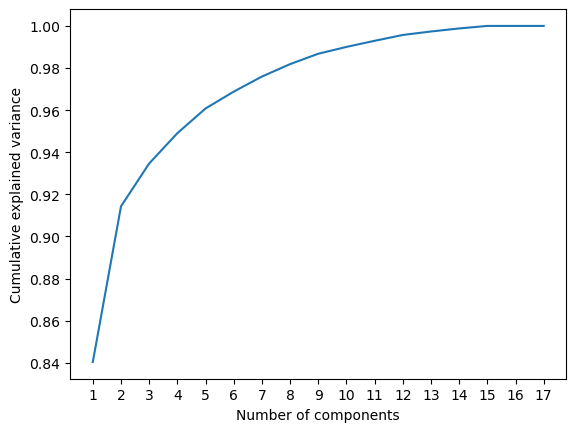

In [37]:
# Coputing the convariance matrix
cov = (features_scaled.T @ features_scaled) / (features_scaled.shape[0] - 1)

eig_values, eig_vectors = np.linalg.eig(cov)


idx = np.argsort(eig_values, axis=0)[::-1]
sorted_eig_vectors = eig_vectors[:, idx]



cumsum = np.cumsum(eig_values[idx]) / np.sum(eig_values[idx])
xint = range(1, len(cumsum) + 1)
plt.plot(xint, cumsum)

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.xticks(xint)

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

model = LogisticRegression(solver='liblinear', multi_class='ovr')

rfe = RFE(estimator=model, n_features_to_select=5)


rfe.fit(x, target)


selected_features = rfe.get_support(indices=True)
print("Selected feature indices:", selected_features)


selected_feature_names = np.array(feature_names)[selected_features]
print("Selected feature names:", selected_feature_names)

Selected feature indices: [ 4  5  6 10 16]
Selected feature names: ['Coded FTR_rolling' 'HS_rolling' 'AS_rolling' 'AC_rolling'
 'League Table Difference']


C:\Users\Tani\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Tani\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Tani\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Tani\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

In [78]:
features = features_for_pca[[ 
    'Coded FTR_rolling','AS_rolling','HS_rolling','AC_rolling','League Table Difference' ]]

In [79]:
#Splitting the data into testing and training sets
X_train, X_val,\
    Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.2,random_state = 22)
  
X_train.shape, X_val.shape

((448, 5), (112, 5))

In [80]:
# Define the neural network model
def create_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae','accuracy'])
    return model

# num_features is the number of input features
model = create_model(5)


history = model.fit(X_train, Y_train, epochs=100)

Epoch 1/100
14/14 [==============================] - 1s 9ms/step - loss: 3.9944 - mae: 1.5061 - accuracy: 0.2366
Epoch 2/100
14/14 [==============================] - 0s 7ms/step - loss: 3.8216 - mae: 1.4719 - accuracy: 0.2366
Epoch 3/100
14/14 [==============================] - 0s 7ms/step - loss: 3.6499 - mae: 1.4504 - accuracy: 0.2411
Epoch 4/100
14/14 [==============================] - 0s 7ms/step - loss: 3.5350 - mae: 1.4324 - accuracy: 0.2344
Epoch 5/100
14/14 [==============================] - 0s 6ms/step - loss: 3.4032 - mae: 1.4142 - accuracy: 0.2366
Epoch 6/100
14/14 [==============================] - 0s 6ms/step - loss: 3.2800 - mae: 1.3886 - accuracy: 0.2366
Epoch 7/100
14/14 [==============================] - 0s 6ms/step - loss: 3.2330 - mae: 1.3780 - accuracy: 0.2500
Epoch 8/100
14/14 [==============================] - 0s 7ms/step - loss: 3.1612 - mae: 1.3665 - accuracy: 0.2455
Epoch 9/100
14/14 [==============================] - 0s 6ms/step - loss: 3.1255 - mae: 1.3644 - 

In [82]:
predictions = model.predict(X_val)

string = Y_val.to_string()
#print(Y_val.to_string())


# Split data into lines
lines = string.split("\n")

# Extract values without the numbers in front
values = [line.split()[-1] for line in lines]

# Print the values
for value in values:
    print(value)


for element in predictions:
    print(element[0])


4/4 [==============================] - 0s 4ms/step
Difference
0
-1
3
0
-1
-2
4
3
2
0
-1
1
1
4
3
1
0
1
2
1
-2
1
-4
0
0
2
-1
-1
2
1
0
0
2
-1
-1
-2
2
-3
0
-1
0
0
4
4
-1
1
-1
-2
1
1
2
-5
1
0
1
0
-1
0
-2
1
1
0
0
0
-3
0
-2
1
-1
1
0
1
1
3
2
-1
-1
1
-1
-2
-1
-2
-1
-3
0
1
-2
1
1
0
0
-6
0
2
-1
-1
0
1
2
-1
1
-1
-1
1
-2
0
-1
-1
-4
4
0
5
-0.11912222
-1.8333197
0.4928213
1.2211201
0.0949233
-1.3465959
1.6841669
0.21030074
0.8546671
-1.5435274
-0.749515
0.48714417
1.8929749
-0.39806107
0.7702979
-1.3083969
-0.27552933
-1.5559367
0.6771533
0.29350302
-0.3944806
0.7583139
-1.9358875
0.39597145
-0.70260113
1.3101281
-1.7146106
-1.6695259
2.3612454
-0.45455882
0.25428745
0.55446833
1.1917967
0.53386116
-0.31845072
-0.21906368
0.6605899
-0.6409837
0.45517674
0.5627348
-0.5864044
1.1255195
1.2053834
1.6929822
-0.8104252
2.0047643
-0.18001524
-0.40540537
0.35180828
0.24203144
-0.1252093
-1.9063563
-0.06410053
1.2746574
1.9458512
0.567517
-0.55032516
0.38353473
0.49096972
-1.1926167
-0.13593543
0.2737633
-0.